### Dedupe needs more setup therefore a notebook so i can handle it step by Step


In [2]:
import rdflib

ttl_path = "data/healthcare_graph_original_v2.ttl"

def extract_dedupe_fields_from_ttl(ttl_path):
    g = rdflib.Graph()
    g.parse("data/healthcare_graph_original_v2.ttl")
    
    # Map: {entity_type: set([literal_predicate_names])}
    type_predicate_map = {}
    
    for s in set(g.subjects()):
        # Get type
        types = [str(o) for o in g.objects(s, rdflib.RDF.type)]
        if not types:
            continue
        type_ = types[0].split("/")[-1]  # Or use more sophisticated logic if needed
        
        # Gather literal predicates
        predicates = set()
        for p, o in g.predicate_objects(s):
            if isinstance(o, rdflib.Literal):
                pred_name = p.split("/")[-1] if "/" in str(p) else str(p)
                predicates.add(pred_name)
        if type_ not in type_predicate_map:
            type_predicate_map[type_] = set()
        type_predicate_map[type_].update(predicates)
    
    # Build dedupe.io field definitions per entity type
    dedupe_fields = {}
    for type_, preds in type_predicate_map.items():
        dedupe_fields[type_] = [
            {'field': pred, 'type': 'String'} for pred in preds if pred.lower() != "identifier"
]

    return dedupe_fields

fields_per_type = extract_dedupe_fields_from_ttl("data/healthcare_graph_original_v2.ttl")
for entity_type, fields in fields_per_type.items():
    print(f"Entity type: {entity_type}")
    print(fields)
    print()

Entity type: PostalAddress
[{'field': 'streetAddress', 'type': 'String'}, {'field': 'addressCountry', 'type': 'String'}, {'field': 'postalCode', 'type': 'String'}, {'field': 'addressLocality', 'type': 'String'}]

Entity type: Person
[{'field': 'email', 'type': 'String'}, {'field': 'knowsLanguage', 'type': 'String'}, {'field': 'jobTitle', 'type': 'String'}, {'field': 'birthDate', 'type': 'String'}, {'field': 'name', 'type': 'String'}, {'field': 'gender', 'type': 'String'}]

Entity type: ContactPoint
[{'field': 'contactType', 'type': 'String'}, {'field': 'availableLanguage', 'type': 'String'}, {'field': 'telephone', 'type': 'String'}, {'field': 'email', 'type': 'String'}, {'field': 'faxNumber', 'type': 'String'}]

Entity type: Department
[{'field': 'name', 'type': 'String'}]

Entity type: MedicalOrganization
[{'field': 'name', 'type': 'String'}]



In [3]:
from modular_methods.graphToText_utils import kg_to_dedupe_dict
g = rdflib.Graph()
g1 = rdflib.Graph()
g2 = rdflib.Graph()
g.parse("data/healthcare_graph_original_v2.ttl")
g1.parse("data/prog_data/healthcare_graph_progdups.ttl")# sample of the first 15 HCO's
g2.parse("data/train_data/healthcare_graph_replaced_train.ttl")# sample of the other 35 HCO's 
dict1 = kg_to_dedupe_dict(g)
dict2 = kg_to_dedupe_dict(g1)
train_dict = kg_to_dedupe_dict(g2)   

In [4]:
import json
with open("data/dedupe_data/dict1.json", "w") as f:
    json.dump(dict1, f, indent=2)
with open("data/dedupe_data/dict2.json", "w") as f:
    json.dump(dict2, f, indent=2)
with open("data/dedupe_data/train_dict.json", "w") as f:
    json.dump(train_dict, f, indent=2)

## Ground truth for test data

In [5]:
import pandas as pd 
golden_standard = pd.read_csv('data/prog_data/updated_golden_standard_duplicates2.csv')

# Replace entity types
golden_standard['entity_type'] = golden_standard['entity_type'].replace({
    'HealthcareOrganization': 'HealthcareOrg',
    'ServiceDepartment': 'ServiceDept'
})

golden_standard_subset = golden_standard[['original_id', 'duplicate_id', 'entity_type']]
golden_standard_subset_var = golden_standard[['original_id', 'duplicate_id', 'entity_type','variation_type']]


ground_truth_test = {}

# Mapping to Person for both Person and HealthcarePersonnel
for entity in golden_standard_subset_var['entity_type'].unique():
    df_filtered = golden_standard_subset_var[golden_standard_subset_var['entity_type'] == entity]
    entity_for_uri = "Person" if entity in ["Person", "HealthcarePersonnel"] else entity
    # Use 'Person' as the key for both types
    key = "Person" if entity in ["Person", "HealthcarePersonnel"] else entity
    if key not in ground_truth_test:
        ground_truth_test[key] = []
    ground_truth_test[key].extend([
        (f"http://example.org/{entity_for_uri}/{row['original_id']}", 
         f"http://example.org/{entity_for_uri}/{row['duplicate_id']}")
        for _, row in df_filtered.iterrows()
    ])

test_GT_Person = ground_truth_test['Person']

In [6]:
ground_truth_test

{'Address': [('http://example.org/Address/0e8cff18-9e9d-4b77-ba34-b580eda0a0af',
   'http://example.org/Address/b43baeb2-62b1-4c36-99a2-e67258cf1235'),
  ('http://example.org/Address/1095e497-3d79-4f0b-a6cd-3595d4f0d65d',
   'http://example.org/Address/679dbeb2-2136-402b-811b-c2471abca0b2'),
  ('http://example.org/Address/3899c22a-d4ed-41bd-9692-74a2acbe4ff6',
   'http://example.org/Address/32fd16b8-2e2d-4257-9bd2-e411bfc5e5ce'),
  ('http://example.org/Address/541d1a81-4815-442c-a2bb-62833d83ad7c',
   'http://example.org/Address/a26599c2-c1e3-4595-982d-515d344bbc43'),
  ('http://example.org/Address/603fa8f0-1549-4dee-830b-4d6d9575d095',
   'http://example.org/Address/bd4cf3d7-3c27-4645-99bd-a9a62e2d500a'),
  ('http://example.org/Address/eedbba8b-0f83-41ee-b2ac-89bdb2998fa3',
   'http://example.org/Address/e9b93ff7-1d3c-4297-b080-5fb4cb77938d'),
  ('http://example.org/Address/853a9135-3ee2-451b-be88-c93319db1d7b',
   'http://example.org/Address/fdce7129-5e40-43ea-96e2-a428d9964a8c'),
  

### Perform the manual labelling on train data NOT on test data

In [7]:


golden_standard = pd.read_csv('data/train_data/train_golden_standard_duplicates_final.csv')

# Replace entity types
golden_standard['entity_type'] = golden_standard['entity_type'].replace({
    'HealthcareOrganization': 'HealthcareOrg',
    'ServiceDepartment': 'ServiceDept'
})

golden_standard_subset = golden_standard[['original_id', 'duplicate_id', 'entity_type']]
golden_standard_subset_var = golden_standard[['original_id', 'duplicate_id', 'entity_type','variation_type']]


ground_truth_train = {}

# Mapping to Person for both Person and HealthcarePersonnel
for entity in golden_standard_subset_var['entity_type'].unique():
    df_filtered = golden_standard_subset_var[golden_standard_subset_var['entity_type'] == entity]
    entity_for_uri = "Person" if entity in ["Person", "HealthcarePersonnel"] else entity
    # Use 'Person' as the key for both types
    key = "Person" if entity in ["Person", "HealthcarePersonnel"] else entity
    if key not in ground_truth_train:
        ground_truth_train[key] = []
    ground_truth_train[key].extend([
        (f"http://example.org/{entity_for_uri}/{row['original_id']}", 
         f"http://example.org/{entity_for_uri}/{row['duplicate_id']}")
        for _, row in df_filtered.iterrows()
    ])

# Instead of taking first 50 Person pairs, select 7 per variation type
person_variations = golden_standard_subset_var[
    (golden_standard_subset_var['entity_type'] == 'Person') | 
    (golden_standard_subset_var['entity_type'] == 'HealthcarePersonnel')
]

person_variations

,original_id,duplicate_id,entity_type,variation_type
512,6f3bf8cb-c3a3-44d4-b069-54181eba1b4d,1f922490-361f-4edb-ac99-72e6d80b7a8d,Person,language_expansion
513,6f3bf8cb-c3a3-44d4-b069-54181eba1b4d,5313feee-9263-4e25-8cbe-0fd741fdd203,HealthcarePersonnel,email_typo
514,442f4f75-7f76-4e05-abd3-3f5acd13b341,cda9ac1a-14da-425c-8d22-1f4c6a5a1bda,Person,abbreviated_first_name
515,2d9e3366-4262-4e48-8a17-e18ea41df089,e37e9d26-6409-4755-adec-980c13d89011,Person,date_format_variation
516,2d9e3366-4262-4e48-8a17-e18ea41df089,e37e9d26-6409-4755-adec-980c13d89011,HealthcarePersonnel,email_typo
...,...,...,...,...
1967,758467b7-65d4-4a6c-a258-1cec772004e6,45e53dff-6049-4666-832e-b99bacc4d5e6,HealthcarePersonnel,email_typo
1968,58a550c1-e4b4-45e0-9fec-ace9aace7a2d,e1c77b7f-43e1-4317-b038-8a6ac54b393d,HealthcarePersonnel,email_typo
1969,16c7f379-4132-42ac-8fb4-4a78c9193878,9888aad7-7aea-4174-ac45-22aa3d56f677,HealthcarePersonnel,email_typo
1970,5a37955a-83e5-4f91-bb14-bfbf3c8d5aa5,ab54ca42-46c2-4be2-9d90-d917052edbc3,HealthcarePersonnel,email_typo


In [8]:
# Get 7 examples per variation type
GT_Person_by_variation = []
for variation_type in person_variations['variation_type'].unique():
    variation_pairs = person_variations[person_variations['variation_type'] == variation_type]
    
    # Take up to 7 pairs for this variation type
    selected_pairs = variation_pairs.head(20)
    
    for _, row in selected_pairs.iterrows():
        GT_Person_by_variation.append((
            f"http://example.org/Person/{row['original_id']}", 
            f"http://example.org/Person/{row['duplicate_id']}"
        ))

# Replace your existing GT_Person line with:
GT_Person = GT_Person_by_variation

print(f"Total Person pairs selected: {len(GT_Person)}")
print(f"Variation types: {person_variations['variation_type'].unique()}")

# Check distribution
for variation_type in person_variations['variation_type'].unique():
    count = len(person_variations[person_variations['variation_type'] == variation_type].head(20))
    print(f"{variation_type}: {count} pairs")



GT_HCO = ground_truth_train['HealthcareOrg'][:10] # print first 10 pairs


import random


def sample_distinct_pairs(golden_standard_subset, ground_truth_pairs, entity_type, n_neg=3):
    """Sample distinct pairs for dedupe.io (negatives), avoiding ground truth."""
    filtered = golden_standard_subset[golden_standard_subset['entity_type'] == entity_type]
    all_ids1 = filtered['original_id'].unique()
    all_ids2 = filtered['duplicate_id'].unique()
    gt_set = set(ground_truth_pairs)
    distinct_pairs = set()
    attempts = 0
    max_attempts = len(gt_set) * n_neg * 10  # Prevent infinite loop
    
    while len(distinct_pairs) < len(gt_set) * n_neg and attempts < max_attempts:
        a, b = random.choice(all_ids1), random.choice(all_ids2)
        if (a, b) not in gt_set and (b, a) not in gt_set and (a, b) not in distinct_pairs:
            distinct_pairs.add((f"http://example.org/{entity_type}/{a}", f"http://example.org/{entity_type}/{b}"))
        attempts += 1
    return list(distinct_pairs)

entity_types = ['Address', 'Person', 'HealthcareOrg', 'ServiceDept', 'ContactPoint']
distinct_pairs = {}
for entity_type in entity_types:
    negatives = sample_distinct_pairs(
        golden_standard_subset, ground_truth_train[entity_type], entity_type, n_neg=3
    )
    distinct_pairs[entity_type] = negatives

DP_Ad = distinct_pairs['Address'][:10]   
DP_Person = distinct_pairs['Person'][:100]
DP_HCO = distinct_pairs['HealthcareOrg'][:10]
DP_SD = distinct_pairs['ServiceDept'][:10]
DP_CP = distinct_pairs['ContactPoint'][:10]



Total Person pairs selected: 120
Variation types: ['language_expansion' 'email_typo' 'abbreviated_first_name'
 'date_format_variation' 'name_swap' 'name_typo']
language_expansion: 20 pairs
email_typo: 20 pairs
abbreviated_first_name: 20 pairs
date_format_variation: 20 pairs
name_swap: 20 pairs
name_typo: 20 pairs


In [9]:
GT_Person

[('http://example.org/Person/6f3bf8cb-c3a3-44d4-b069-54181eba1b4d',
  'http://example.org/Person/1f922490-361f-4edb-ac99-72e6d80b7a8d'),
 ('http://example.org/Person/cd873b6d-01fa-4ef3-b2a8-35dcb55a0796',
  'http://example.org/Person/36267584-22fa-43dc-96a6-b5ac17bb5a7d'),
 ('http://example.org/Person/bfe95dfe-7822-47dd-a3de-42bbd777a742',
  'http://example.org/Person/7ae2709e-8d79-4010-8a65-b55c716bf54e'),
 ('http://example.org/Person/56192246-19b7-46c1-9aeb-1fbc196b3c22',
  'http://example.org/Person/36267584-22fa-43dc-96a6-b5ac17bb5a7d'),
 ('http://example.org/Person/19dc80b2-ebee-411c-aa36-05199fea5aa9',
  'http://example.org/Person/1f922490-361f-4edb-ac99-72e6d80b7a8d'),
 ('http://example.org/Person/1847b3f9-1c58-4588-bc73-44bb7e1f8d5c',
  'http://example.org/Person/7ae2709e-8d79-4010-8a65-b55c716bf54e'),
 ('http://example.org/Person/9718249b-5130-4d58-bac3-8a289d9bc00f',
  'http://example.org/Person/7ae2709e-8d79-4010-8a65-b55c716bf54e'),
 ('http://example.org/Person/c570e7d0-af1

In [10]:
# Map of entity type to dedupe.io fields
ENTITY_FIELDS = {
    "Person": [
        {'field': 'knowsLanguage', 'type': 'String'},
        {'field': 'jobTitle', 'type': 'String'},
        {'field': 'name', 'type': 'String'},
        {'field': 'birthDate', 'type': 'String'},
        {'field': 'gender', 'type': 'String'},
        {'field': 'email', 'type': 'String'}
    ],
    "ContactPoint": [
        {'field': 'faxNumber', 'type': 'String'},
        {'field': 'availableLanguage', 'type': 'String'},
        {'field': 'telephone', 'type': 'String'},
        {'field': 'email', 'type': 'String'},
        {'field': 'contactType', 'type': 'String'}
    ],
    "Department": [
        {'field': 'name', 'type': 'String'}
    ],
    "PostalAddress": [
        {'field': 'addressLocality', 'type': 'String'},
        {'field': 'streetAddress', 'type': 'String'},
        {'field': 'postalCode', 'type': 'String'},
        {'field': 'addressCountry', 'type': 'String'}
    ],
    "MedicalOrganization": [
        {'field': 'name', 'type': 'String'}
    ]
}

import dedupe
import dedupe.variables

ENTITY_FIELDS_dedup= {"Person": [
        dedupe.variables.String("knowsLanguage"),
        dedupe.variables.String("jobTitle"),
        dedupe.variables.String("name"),
        dedupe.variables.String("birthDate"),
        dedupe.variables.String("gender"),
        dedupe.variables.String("email")
    ],
    "ContactPoint": [
        dedupe.variables.String("faxNumber"),
        dedupe.variables.String("availableLanguage"),
        dedupe.variables.String("telephone"),
        dedupe.variables.String("email"),
        dedupe.variables.String("contactType")
    ],
    "Department": [
        dedupe.variables.String("name")
    ],
    "PostalAddress": [
        dedupe.variables.String("addressLocality"),
        dedupe.variables.String("streetAddress"),
        dedupe.variables.String("postalCode"),
        dedupe.variables.String("addressCountry")
    ],
    "MedicalOrganization": [
        dedupe.variables.String("name")
    ]}



def filter_entity(d, entity_type):
    search_str = f"/{entity_type}/"
    return {k: v for k, v in d.items() if search_str in k}

person_dict1 = filter_entity(dict1, "Person")
person_dict2 = filter_entity(dict2, "Person")
train_person_dict1 = filter_entity(train_dict, "Person")


In [11]:
GT_Person

[('http://example.org/Person/6f3bf8cb-c3a3-44d4-b069-54181eba1b4d',
  'http://example.org/Person/1f922490-361f-4edb-ac99-72e6d80b7a8d'),
 ('http://example.org/Person/cd873b6d-01fa-4ef3-b2a8-35dcb55a0796',
  'http://example.org/Person/36267584-22fa-43dc-96a6-b5ac17bb5a7d'),
 ('http://example.org/Person/bfe95dfe-7822-47dd-a3de-42bbd777a742',
  'http://example.org/Person/7ae2709e-8d79-4010-8a65-b55c716bf54e'),
 ('http://example.org/Person/56192246-19b7-46c1-9aeb-1fbc196b3c22',
  'http://example.org/Person/36267584-22fa-43dc-96a6-b5ac17bb5a7d'),
 ('http://example.org/Person/19dc80b2-ebee-411c-aa36-05199fea5aa9',
  'http://example.org/Person/1f922490-361f-4edb-ac99-72e6d80b7a8d'),
 ('http://example.org/Person/1847b3f9-1c58-4588-bc73-44bb7e1f8d5c',
  'http://example.org/Person/7ae2709e-8d79-4010-8a65-b55c716bf54e'),
 ('http://example.org/Person/9718249b-5130-4d58-bac3-8a289d9bc00f',
  'http://example.org/Person/7ae2709e-8d79-4010-8a65-b55c716bf54e'),
 ('http://example.org/Person/c570e7d0-af1

In [12]:
dict1

{'http://example.org/Address/a75a7cfe-d10a-4fe7-96f9-9be1aefe132b': {'addressCountry': 'NL',
  'addressLocality': 'Udenhout',
  'postalCode': '8151 AR',
  'streetAddress': 'Milanpad 127'},
 'http://example.org/Person/8a94c42a-1422-4866-b3c7-b6d42f0a6c4b': {'birthDate': '1977-03-05',
  'email': 'chadgreen@healthcare.org',
  'gender': 'Male',
  'jobTitle': 'Dialysis Nurse',
  'knowsLanguage': 'et',
  'name': 'Chad Green'},
 'http://example.org/Person/b8d0b72f-3da8-4e21-96a9-19ab1f8f1161': {'birthDate': '1969-05-16',
  'email': 'kathryngonzalez@healthcare.org',
  'gender': 'Male',
  'jobTitle': 'Radiologist',
  'knowsLanguage': 'de',
  'name': 'Kathryn Gonzalez'},
 'http://example.org/Address/9f6622e9-d6b2-41e3-a27b-f978777f4a56': {'addressCountry': 'AT',
  'addressLocality': 'Bischofshofen',
  'postalCode': '8418',
  'streetAddress': 'Stögergasse 56'},
 'http://example.org/ContactPoint/09b521fc-7d51-4f5e-9855-226a6ec6b631': {'availableLanguage': "['et', 'en']",
  'contactType': 'Emergenc

In [13]:
import csv

def pairs_to_records(pair_list, dict1, train_dict):
    return [
        (dict1[a], train_dict[b])
        for a, b in pair_list
        if a in dict1 and b in train_dict
    ]


matches = pairs_to_records(GT_Person, dict1, train_dict)
distinct = pairs_to_records(DP_Person, dict1, train_dict)

matches

def write_pairs_to_csv(pairs, filename):
    """Write pairs of records to a CSV file for manual editing."""
    if not pairs:
        print("No pairs to write.")
        return
    # Get all unique field names from both records in the pairs
    fieldnames = set()
    for rec1, rec2 in pairs:
        fieldnames.update([f"left_{k}" for k in rec1.keys()])
        fieldnames.update([f"right_{k}" for k in rec2.keys()])
    fieldnames = sorted(fieldnames)
    # Add a label column for manual annotation
    fieldnames = ['label'] + fieldnames

    with open(filename, 'w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        for rec1, rec2 in pairs:
            row = {}
            for k, v in rec1.items():
                row[f"left_{k}"] = v
            for k, v in rec2.items():
                row[f"right_{k}"] = v
            row['label'] = ''  # To be filled in manually
            writer.writerow(row)

def read_pairs_from_csv(filename):
    """Read pairs of records from a CSV file (after manual annotation)."""
    pairs = []
    labels = []
    with open(filename, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            rec1 = {k[5:]: v for k, v in row.items() if k.startswith('left_')}
            rec2 = {k[6:]: v for k, v in row.items() if k.startswith('right_')}
            label = row.get('label', '')
            pairs.append((rec1, rec2))
            labels.append(label)
    return pairs, labels

# Example usage:
write_pairs_to_csv(matches, "data/dedupe_data/matches_for_labelling.csv")
write_pairs_to_csv(distinct, "data/dedupe_data/distinct_for_labelling.csv")
# labelled_matches, match_labels = read_pairs_from_csv("matches_for_labelling.csv")

In [14]:
distinct

[({'birthDate': '1973-12-10',
   'email': 'tonyawalker@healthcare.org',
   'gender': 'Female',
   'jobTitle': 'Neonatal Nurse',
   'knowsLanguage': 'de',
   'name': 'Tonya Walker'},
  {'birthDate': '1998-01-30',
   'email': 'hannahloe@healthcare.org',
   'gender': 'Male',
   'jobTitle': 'GI Nurse',
   'knowsLanguage': 'nl',
   'name': 'H. Love'}),
 ({'birthDate': '1965-02-11',
   'email': 'louisrivas@healthcare.org',
   'gender': 'Male',
   'jobTitle': 'Lung Function Technician',
   'knowsLanguage': 'et',
   'name': 'Louis Rivas'},
  {'birthDate': '1992-10-14',
   'email': 'taracopelannd@healthcare.org',
   'gender': 'Female',
   'jobTitle': 'Surgical Nurse',
   'knowsLanguage': 'et',
   'name': 'Talra Copeland'}),
 ({'birthDate': '1994-07-04',
   'email': 'mariagreer@healthcare.org',
   'gender': 'Male',
   'jobTitle': 'Nutritionist',
   'knowsLanguage': 'et',
   'name': 'Maria Greer'},
  {'birthDate': '1973-03-28',
   'email': 'kennnethgomez@healthcare.org',
   'gender': 'Female',
  

In [15]:
# Check what fields are actually available in your person records
print("Sample record from person_dict1:")
sample_key = list(person_dict1.keys())[0]
print(person_dict1[sample_key])

print("\nSample record from train_dict:")
sample_key = list(train_dict.keys())[0]
print(train_dict[sample_key])

Sample record from person_dict1:
{'birthDate': '1977-03-05', 'email': 'chadgreen@healthcare.org', 'gender': 'Male', 'jobTitle': 'Dialysis Nurse', 'knowsLanguage': 'et', 'name': 'Chad Green'}

Sample record from train_dict:
{'addressCountry': 'NL', 'addressLocality': 'Markenbinnen', 'postalCode': '6167 FA', 'streetAddress': 'Lolastraat 72C'}


In [ ]:
training_data = {
    "match": matches,
    "distinct": distinct    
}

linker = dedupe.RecordLink(ENTITY_FIELDS_dedup['Person'])
linker.mark_pairs(training_data)
linker.prepare_training(person_dict1, train_person_dict1, sample_size=400)
linker.train()


In [ ]:
links = linker.join(person_dict1, person_dict2, threshold=0.5)
#list(links)


In [ ]:
list(links)
pairs = [ (str(pair[0][0]), str(pair[0][1])) for pair in links ]

In [ ]:
test_GT_Person

[('http://example.org/Person/5ff5fcc7-1bb9-403e-9cd0-fc8f91b7bcd5',
  'http://example.org/Person/a587452a-a773-43c4-8af4-5a6fe49197a8'),
 ('http://example.org/Person/e0c14dc9-fcc1-40cb-9e3d-55da9fd1f598',
  'http://example.org/Person/e7e3a731-121b-4395-8472-d9f275214880'),
 ('http://example.org/Person/e32873d3-af2b-4a60-baa1-fb842bfea4d7',
  'http://example.org/Person/0094a41b-8316-4c02-b376-e09db1fa1f25'),
 ('http://example.org/Person/35643c30-a542-46f0-9593-4d23d33c1060',
  'http://example.org/Person/e7e3a731-121b-4395-8472-d9f275214880'),
 ('http://example.org/Person/4280ea37-ccd3-42ee-8b73-fb3c5b32db8e',
  'http://example.org/Person/f455292b-22ef-4410-8e6f-170fd3b0be90'),
 ('http://example.org/Person/70fa9c5b-24a4-416a-a95d-1eafd756f058',
  'http://example.org/Person/869740e1-4b82-4923-8166-60c3932476a7'),
 ('http://example.org/Person/48ea5a56-7010-480a-af5c-18a85a12e96f',
  'http://example.org/Person/bccad335-7e72-4a40-b781-010beff9b5a4'),
 ('http://example.org/Person/fe362397-6bc

In [ ]:
extracted_pairs = set(
    (str(pair[0][0]).rsplit('/', 1)[-1], str(pair[0][1]).rsplit('/', 1)[-1])
    for pair in links
)
extracted_pairs


golden_pairs = set(
    (a.rsplit('/', 1)[-1], b.rsplit('/', 1)[-1])
    for a, b in test_GT_Person
)


found = extracted_pairs & golden_pairs

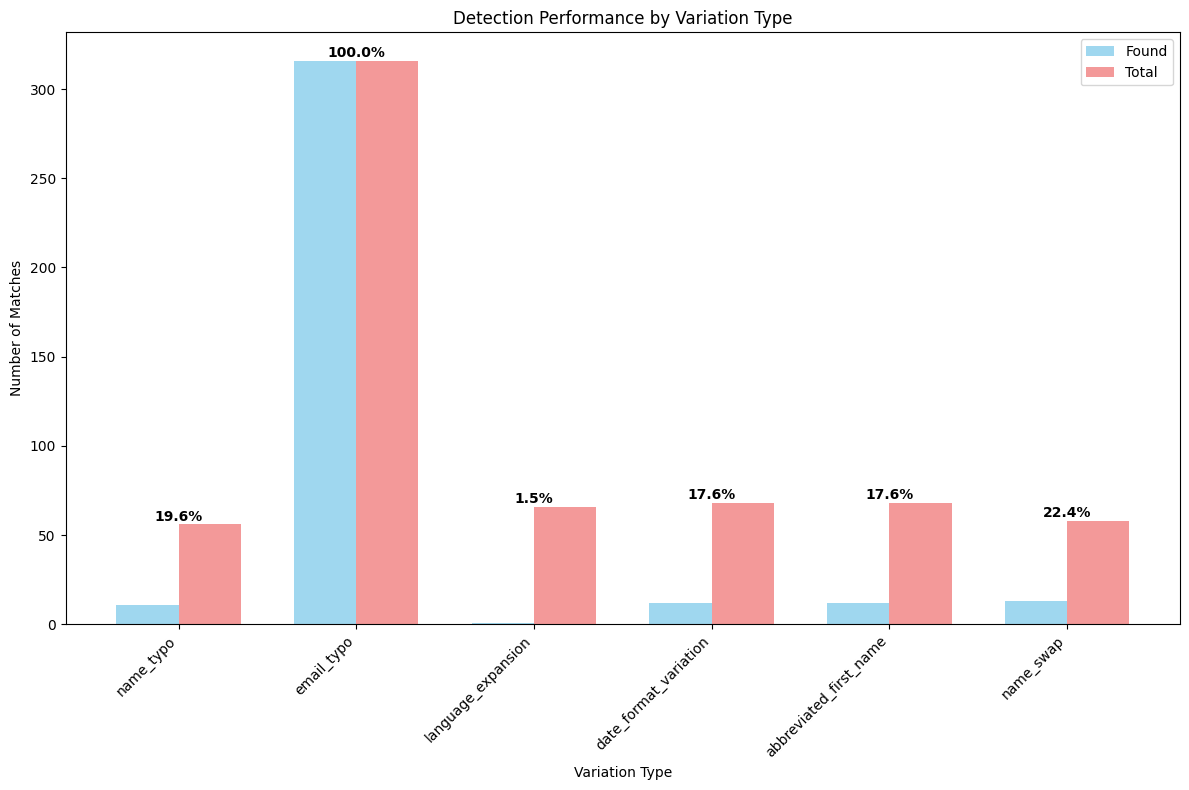

Detection Results by Variation Type:
--------------------------------------------------
name_typo                 |  11/ 56 ( 19.6%)
email_typo                | 316/316 (100.0%)
language_expansion        |   1/ 66 (  1.5%)
date_format_variation     |  12/ 68 ( 17.6%)
abbreviated_first_name    |  12/ 68 ( 17.6%)
name_swap                 |  13/ 58 ( 22.4%)
--------------------------------------------------
Overall                   | 365/632 ( 57.8%)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the golden standard data
golden_standard = pd.read_csv('data/prog_data/updated_golden_standard_duplicates2.csv')

# Replace entity types to match your test data format
golden_standard['entity_type'] = golden_standard['entity_type'].replace({
    'HealthcareOrganization': 'HealthcareOrg',
    'ServiceDepartment': 'ServiceDept'
})

# Filter for Person entities (including HealthcarePersonnel)
person_variations = golden_standard[
    (golden_standard['entity_type'] == 'Person') | 
    (golden_standard['entity_type'] == 'HealthcarePersonnel')
]

# Create a mapping from ID pairs to variation types
variation_lookup = {}
for _, row in person_variations.iterrows():
    key = (row['original_id'], row['duplicate_id'])
    variation_lookup[key] = row['variation_type']

# Convert your found results back to ID pairs
# Assuming 'found' contains tuples like ('id1', 'id2')
found_with_variation = {}

for pair in found:
    if pair in variation_lookup:
        var_type = variation_lookup[pair]
        if var_type not in found_with_variation:
            found_with_variation[var_type] = 0
        found_with_variation[var_type] += 1

# Calculate totals for each variation type
variation_totals = {}
for var_type in person_variations['variation_type'].unique():
    variation_totals[var_type] = len(person_variations[person_variations['variation_type'] == var_type])

# Prepare data for plotting
variation_types = list(variation_totals.keys())
found_counts = [found_with_variation.get(vt, 0) for vt in variation_types]
total_counts = [variation_totals[vt] for vt in variation_types]

# Create the visualization
fig, ax = plt.subplots(figsize=(12, 8))

x = range(len(variation_types))
width = 0.35

bars1 = ax.bar([i - width/2 for i in x], found_counts, width, label='Found', alpha=0.8, color='skyblue')
bars2 = ax.bar([i + width/2 for i in x], total_counts, width, label='Total', alpha=0.8, color='lightcoral')

# Add percentage labels on bars
for i, (found, total) in enumerate(zip(found_counts, total_counts)):
    percentage = (found / total * 100) if total > 0 else 0
    ax.text(i, max(found, total) + 0.5, f'{percentage:.1f}%', 
            ha='center', va='bottom', fontweight='bold')

ax.set_xlabel('Variation Type')
ax.set_ylabel('Number of Matches')
ax.set_title('Detection Performance by Variation Type')
ax.set_xticks(x)
ax.set_xticklabels(variation_types, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

# Print detailed results
print("Detection Results by Variation Type:")
print("-" * 50)
for var_type in variation_types:
    found_count = found_with_variation.get(var_type, 0)
    total_count = variation_totals[var_type]
    percentage = (found_count / total_count * 100) if total_count > 0 else 0
    print(f"{var_type:25} | {found_count:3d}/{total_count:3d} ({percentage:5.1f}%)")

print("-" * 50)
total_found = sum(found_counts)
total_possible = sum(total_counts)
overall_percentage = (total_found / total_possible * 100) if total_possible > 0 else 0
print(f"{'Overall':25} | {total_found:3d}/{total_possible:3d} ({overall_percentage:5.1f}%)")